##Setup

Importing modules, making sure that we are using python 3, sklearn 0.20 or up, and tensorflow 2.x.

The code also sets up the matplolib figure sizesb

In [1]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab
    %tensorflow_version 2.x
except Exception:
    pass

#Tensorflow >= 2.0 required
import tensorflow as tf
assert tf.__version__ >= "2.0"

#Common imports
import numpy as np
import os

#for the same output as the book
np.random.seed(42)

# to plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)

# Where to save figures

PROJECT_ROOT_DIR = "."
CHAPTER_ID = 'ann'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok = True)

def save_fig(fig_id, tight_layout=True,fig_extension="png",
            resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


## Perceptrons

setting max_iter and tol explicitly avoids warnings about an impending change to their default value in future Scikit-learn versions

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2,3)] # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter = 1000, tol=1e-3, random_state=42)
per_clf.fit(X,y)

y_pred = per_clf.predict([[2,0.5]])

In [3]:
y_pred

array([1])

Saving figure perceptron_iris_plot


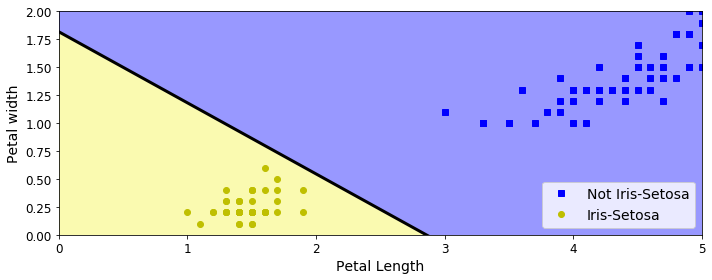

In [4]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0,5,0,2]

x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1,1),
    np.linspace(axes[2], axes[3], 200).reshape(-1,1),
)
X_new = np.c_[x0.ravel(),x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10,4))
plt.plot(X[y==0,0],X[y==0,1],"bs",label="Not Iris-Setosa")
plt.plot(X[y==1,0],X[y==1,1],"yo",label="Iris-Setosa")

plt.plot([axes[0], axes[1]],
         [a * axes[0] + b, a * axes[1] + b],"k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0,x1,zz,cmap=custom_cmap)
plt.xlabel("Petal Length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize = 14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

## Activation Functions

The reason for the activation functions is that otherwise there will be no Gradient Descent for the step function. 

The sigmoid function has a well-defined nonzero derivative at all values, allowing for progress with Gradient Descent.

The tanh function ranges from -1 to 1 instead of 0 to 1 like the sigmoid. Being centered around 0 at initialization helps speed up convergence.

The relu function is continuous but has no slope at z = 0, this can make Gradient Descent bounce around, and its derivative is 0 for z < 0. It however is fast to compute and doesn't have a maximum value which helps with some issues in Gradient Descent. 

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0,z)

# Finite difference approximation of derivation
# Also called Newton's difference quotient
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

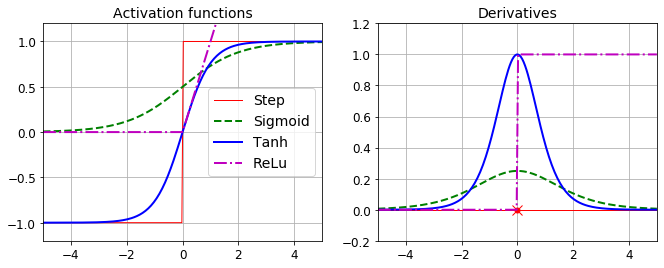

In [6]:
z = np.linspace(-5,5,200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z,np.sign(z),"r-",linewidth=1,label="Step")
plt.plot(z,sigmoid(z),"g--",linewidth=2,label="Sigmoid")
plt.plot(z,np.tanh(z),"b-",linewidth=2,label="Tanh")
plt.plot(z,relu(z),"m-.",linewidth=2,label='ReLu')
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions",fontsize=14)
plt.axis([-5,5,-1.2,1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign,z), "r-",linewidth=1,label="Step")
plt.plot(0,0,'ro',markersize=5)
plt.plot(0,0,'rx',markersize=10)
plt.plot(z, derivative(sigmoid,z),"g--",linewidth=2,label="Sigmoid")
plt.plot(z, derivative(np.tanh,z),"b-",linewidth=2,label="Tanh")
plt.plot(z, derivative(relu,z),"m-.",linewidth=2,label="ReLu")
#plt.grid shows the grid behind the graph
plt.grid(True)
plt.title("Derivatives", fontsize=14)
plt.axis([-5,5,-0.2,1.2])

plt.show()

## Regression with Multilayer Perceptrons

To use perceptrons for regression, all thats needed is to have one output neuron per dimension.

Dont use activation functions so that output can be in any range of values. 

If you want to guarantee the output will be positive, you can use ReLu on the final layer (softplus is a smooth variant, softplus(z) = log(1 + exp(z)), that can be an alternative).

If the output needs to be in a certain range of values use either the logistic function or hyperbolic tangent and then scale the labels to the appropriate range. (0, 1) logitistic, (-1,1) tangent.

The *Loss* function typically is MSE, mean squared error, but if there are many outliers, might use mean absolute error, MAE. Or even Huber loss, which uses both.

Huber loss: Is quadratic when the error is smaller than a threshold *X* (typically 1) but linear when the error is larger than *X*. The linear part makes it less sensitive to outliers than MSE and the quadratic part allows it to converge faster and be more precise than MAE. 

## Classification with MLP's



In [2]:
import tensorflow as tf
from tensorflow import keras
keras.__version__

'2.4.0'

In [4]:
tf.__version__

'2.3.0'

In [9]:
# the fashion MNIST dataset in Keras comes already split
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()


There are 60,000 images, each 28x28 pixels

In [10]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [11]:
X_train_full.dtype

dtype('uint8')

Splitting full training set into a validation set and (smaller) training set. We also scale the pixel intensities down to the 0-1 range an convert them to floats, by dividing by 255.

In [12]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] /255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Plotting an image with matplotlib imshow() function using the 'binary' color map:

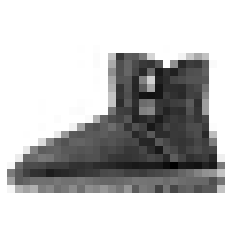

In [13]:
plt.imshow(X_train[4], cmap='binary')
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [14]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [16]:
class_names[y_train[4]]

'Ankle boot'

The validatoin set has 5000 images, an the test set has 10,000 images:

In [17]:
X_valid.shape

(5000, 28, 28)

In [18]:
X_test.shape

(10000, 28, 28)

Looking at a sample of the images in the dataset:

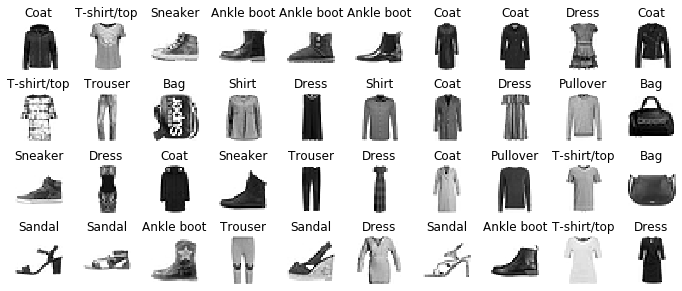

In [19]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows,n_cols,index+1)
        #interpolation determines img quality
        plt.imshow(X_train[index], cmap='binary',interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [20]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [21]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [23]:
model.layers

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [25]:
keras.utils.plot_model(model,"my_fashion_mnist_model.png",
                      show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [26]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [27]:
model.get_layer(hidden1.name) is hidden1

True

The weights have been initialized randomly to break symmetry, and the biaes set to zero. If I want to set a different initialization method, have to set the kernel_initializer or bias_initializer for each layer. 

Kernel is a name for matrix of connection weights.

In [28]:
weights,biases = hidden1.get_weights()

In [29]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [30]:
weights.shape

(784, 300)

In [31]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [32]:
biases.shape

(300,)

In [33]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

This is equivalent to:

    model.compile(loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.SGD(),
    metrics=[keras.metrics.sparse_categorical_accuracy]
    )

In [34]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid,y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7237 - accuracy: 0.7643 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4843 - accuracy: 0.8317 - val_loss: 0.4350 - val_accuracy: 0.8536
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4392 - accuracy: 0.8456 - val_loss: 0.5355 - val_accuracy: 0.7970
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4123 - accuracy: 0.8566 - val_loss: 0.3919 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3937 - accuracy: 0.8618 - val_loss: 0.3741 - val_accuracy: 0.8686
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3750 - accuracy: 0.8675 - val_loss: 0.3720 - val_accuracy: 0.8730
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3632 - accuracy: 0.8715 - val_loss: 0.3614 - val_accuracy:

### Some tips:

Instead of using the `validation_data` argument, set `validation_split` to the ratio that you want to usefor validation. It will use the last, say 10%, of the data (before shuffling) for validation

If the training set is skewed, the `class_weight` argument can let the fit method know and Keras will compute loss accordingly.

If per-instance weight is needed, use `sample_weight`.
If both `class_weight` and `sample_weight` are provided, they will be multiplied. Per-instance weights are useful if for example, some data was labelled by experts and others not.  

In [35]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [36]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [4]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
save_fig("keras_learning_curves_plot")
plt.show()

NameError: name 'history' is not defined

Validation set is computed at the end of each epoch, while training set is computed during each epoch, which accounts for their difference at the start.

In [39]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3372 - accuracy: 0.8825


[0.33723148703575134, 0.8824999928474426]

In [40]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [41]:
y_pred = model.predict_classes(X_new)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([9, 2, 1])

In [42]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [43]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

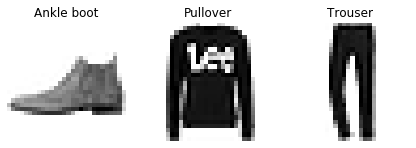

In [45]:
plt.figure(figsize=(7.2,2.4))
for index, image in enumerate(X_new):
    plt.subplot(1,3, index+1)
    plt.imshow(image,cmap='binary',interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Regression MLP

In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
model = keras.models.Sequential([
    keras.layers.Dense(30,activation="relu",input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error",optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                   validation_data = (X_valid,y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4875 - val_loss: 0.4656

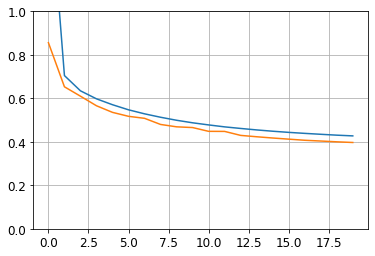

In [49]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [50]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022797 ]], dtype=float32)

## Functional API

This is a *Wide and Deep* network using the Functional API. It sends the input data along the hidden layers but also on a different route straight to the concat layer to capture simple patterns as well the complex ones.


In [51]:
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30,activation="relu")(input_)
hidden2 = keras.layers.Dense(30,activation="relu")(hidden1)
concat = keras.layers.concatenate([input_,hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [55]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 30)           270         input_3[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 30)           930         dense_11[0][0]                   
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 38)           0           input_3[0][0]                    
                                                                 dense_12[0][0]             

In [56]:
model.compile(loss="mean_squared_error",optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid,y_valid))
mse_test = model.evaluate(X_test,y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8422 - val_loss: 1.7479
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7258 - val_loss: 0.7584
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6472 - val_loss: 0.6156
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5944 - val_loss: 0.5442
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5538 - val_loss: 0.5013
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5217 - val_loss: 0.4749
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4970 - val_loss: 0.4519
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4784 - val_loss: 0.4399
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4633 - val_loss: 0.4288
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4515 - val_loss: 0.4316

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

If I want to send different subsets of input features through the wide or deep paths:

In this example, 5 features(features 0 to 4) go through the wide path and 6 features(features 2 to 7) through the deep path. There is overlap in features 2,3,4.

In [58]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30,activation="relu")(input_B)
hidden2 = keras.layers.Dense(30,activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A,hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B],
                          outputs=[output])

In [59]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:,:5], X_train[:,2:]
X_valid_A, X_valid_B = X_valid[:,:5], X_valid[:,2:]
X_test_A, X_test_B = X_test[:,:5], X_test[:,2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B),y_train, epochs=20,
                    validation_data = ((X_valid_A,X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A,X_test_B), y_test)

y_pred = model.predict((X_new_A,X_new_B))


Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4644 - val_loss: 0.4315

### Use cases for multiple outputs:

- The task may demand it. Example, locating the main object in a picture. That is both a regression(locate coordinates of objects center) and classification.
- Multiple independent tasks. The network can learn features that are useful across tasks.
- A regularization technique. Adding auxilary outputs to ensure that so that the underlying part of the network learns something on its own, without relying on the rest of the network (???? not sure how this regularizes...) In the diagram of the network, it would be auxiliary outputing at the step where the multiple inputs are concatanated. 

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30,activation="relu")(input_B)
hidden2 = keras.layers.Dense(30,activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A,hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1,name="aux_output")(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output,aux_output])


In [62]:
model.compile(loss=["mse","mse"], loss_weights=[0.9,0.1],optimizer="sgd")


In [63]:
history = model.fit([X_train_A,X_train_B],[y_train,y_train],
                   epochs=20, validation_data=([X_valid_A,X_valid_B],[y_valid,y_valid]))


Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8602 - main_output_loss: 0.7458 - aux_output_loss: 1.8899 - val_loss: 5.9702 - val_main_output_loss: 6.3391 - val_aux_output_loss: 2.6507
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5736 - main_output_loss: 0.5210 - aux_output_loss: 1.0469 - val_loss: 1.4693 - val_main_output_loss: 1.3954 - val_aux_output_loss: 2.1342
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5078 - main_output_loss: 0.4649 - aux_output_loss: 0.8936 - val_loss: 1.8651 - val_main_output_loss: 1.9608 - val_aux_output_loss: 1.0039
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4619 - main_output_loss: 0.4275 - aux_output_loss: 0.7711 - val_loss: 0.4492 - val_main_output_loss: 0.4084 - val_aux_output_loss: 0.8163
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4417 - main_output_loss: 0.4131 - aux_output_loss: 0.6997 - val_loss

In [64]:
total_loss, main_loss, aux_loss = model.evaluate(
[X_test_A,X_test_B], [y_test,y_test])

162/162 [==============================] - 0s 2ms/step - loss: 0.3608 - main_output_loss: 0.3480 - aux_output_loss: 0.4754


In [65]:
y_pred_main, y_pred_aux = model.predict([X_new_A,X_new_B])

## The Subclassing API

The Sequential and Functional API are great for analysis and ease of reading but they are static. For more dynamic behaviours, use Subclassing API.

Pros:
- Flexibility and dynamic behaviour

Cons:
- Model archeticture is hidden in call() method so Keras cant easily inspect it
- Cannot save or clone it
- summary() method only return layers and not how they're connected
- Keras cannot check shapes and types, so easier to make a mistake

In [66]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30,activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units,activation=activation)
        self.hidden2 = keras.layers.Dense(units,activation=activation)
        self.main_output =keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
   
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A,hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")    

In [67]:
model.compile(loss='mse',loss_weights=[0.9,0.1],
              optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train,y_train), epochs=10,
                   validation_data=((X_valid_A,X_valid_B),(y_valid,y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A,X_test_B),
                                                (y_test,y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A,X_new_B))

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 1s 3ms/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 2s 5ms/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 1s 4ms/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.5964 - val_

## Saving and Restoring a Model

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [70]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train,y_train,epochs=10,
                   validation_data=(X_valid,y_valid))
mse_test= model.evaluate(X_test,y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4382


In [71]:
model.save("my_keras_model.h5")

In [72]:
model = keras.models.load_model("my_keras_model.h5")

In [73]:
model.predict(X_new)

array([[0.5400236],
       [1.6505971],
       [3.0098243]], dtype=float32)

In [74]:
model.save_weights("my_keras_weights.ckpt")
model.load_weights("my_keras_weights.ckpt")

## Using Callbacks during Training

Callbacks let you specify a list of objects that Keras will call at the start and end of training, at the start and end of an epochj, and even before and after processing each batch. 

In [75]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

This callback, ModelCheckpoint, saves checkpoints during training, at the end of each epoch and regular intervals. We can also have it save only up to the point of the best model with, `save_best_only=True`

In [78]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5",
                                               save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb])
# it will roll back to the best model
model = keras.models.load_model("my_keras_model.h5")
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 2s 5ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 2s 5ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 992us/step - loss: 0.4382


If I otherwise want to stop training early after no measurable increase in validation set, use `callbacks.EarlyStopping`, setting the `patience` to the number of epochs that the training has seen no improvement. They can be combiined to save everything, `callbacks.ModelCheckpoint` in case computer crashes and `callbacks.EarlyStopping` to avoid wasting time and resources.

You can set the number of epochs higher since it will stop on its own. 

In [80]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test,y_test)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3976 - val_lo

I can also create custome callbacks. The naming convention here uses `on_train/test/predict_begin/end()` in the function. The full options are in the documentation.

These are good for debugging evaulations and predictions among other things. 

There are also other callbacks available to use in the the documentation.

In [81]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print ("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [84]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                   validation_data=(X_valid,y_valid),
                   callbacks=[val_train_ratio_cb])

355/363 [============================>.] - ETA: 0s - loss: 0.3299
val/train: 1.08
363/363 [==============================] - 1s 2ms/step - loss: 0.3302 - val_loss: 0.3556


## Tensorboard

Comes pre-installed. Can:
- View the learning curves while training
- compare learning curves between multiple runs
- visualize the computation graph
- analyze training stats
- view images generated by the model
- visualize complex multidimensional data projected down to 3D and auto clutered
- and more!

Requires the program output to a special binary log file called an *event file*. Each binary data record is called a *summary*. The Tensorboard server that gets started up will watch the log directory and auto update the visualizations.

In [6]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

In [7]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_08_26-08_46_21'

In [8]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "relu", input_shape=[8]),
    keras.layers.Dense(30, activation = "relu"),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer= keras.optimizers.SGD(lr=1e-3))


In [10]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                   validation_data = (X_valid, y_valid),
                   callbacks = [tensorboard_cb])

Epoch 1/30
  1/363 [..............................] - ETA: 0s - loss: 7.8215WARNING:tensorflow:From /opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 1s 1ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [=================

In [14]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
%python3 -m tensorboard.main --logdir=./my_logs

UsageError: Line magic function `%python3` not found (But cell magic `%%python3` exists, did you mean that instead?).


In [18]:
run_logdir2= get_run_logdir()
run_logdir2

'./my_logs/run_2020_08_27-06_25_56'

In [19]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.05))

In [23]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5",
                                               save_best_only=True)
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 2s 4ms/step - loss: 0.5530 - val_loss: 302.8536
Epoch 2/30
363/363 [==============================] - 1s 1ms/step - loss: 5292745216.0000 - val_loss: 1.3230
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3411 - val_loss: 1.3176
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 1.3423 - val_loss: 1.3261
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3423 - val_loss: 1.3154
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3431 - val_loss: 1.3203
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3425 - val_loss: 1.3149
Epoch 8/30
363/363 [==============================] - 1s 3ms/step - loss: 1.3433 - val_loss: 1.3157
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 1.3435 - val_loss: 1.3150
Epoch 10/30
363/363 [==============================] - 1s 3ms/step - loss: 1.3423 - val_l

In [24]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



## Hyperparameter Tuning


In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3,
               input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss='mse',optimizer=optimizer)
    return model

In [32]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [33]:
keras_reg.fit(X_train, y_train, epochs=100,
             validation_data=(X_valid, y_valid),
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 1.1971 - val_loss: 1.7696
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6045 - val_loss: 0.5361
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5203 - val_loss: 0.5093
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4783 - val_loss: 0.4392
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4524 - val_loss: 0.4161
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4353 - val_loss: 0.4036
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4249 - val_loss: 0.3930
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4174 - val_loss: 0.3925
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4104 - val_loss: 0.3853
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4056 - val_lo

In [34]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 841us/step - loss: 0.3421


In [35]:
y_pred = keras_reg.predict(X_new)

NameError: name 'X_new' is not defined

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons" : np.arange(1,100),
    "learning_rate" : reciprocal(3e-4,3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs,
                                  n_iter=10,cv=3,verbose=2)
rnd_search_cv.fit(X_train,y_train,epochs=100,
                 validation_data=(X_valid,y_valid),
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Epoch 1/100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


242/242 [==============================] - 0s 2ms/step - loss: 3.5557 - val_loss: 1.8752
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3347 - val_loss: 0.9522
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8591 - val_loss: 0.7820
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7360 - val_loss: 0.7249
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6930 - val_loss: 0.6994
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6668 - val_loss: 0.9118
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6514 - val_loss: 0.8495
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6381 - val_loss: 0.8605
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6276 - val_loss: 0.6524
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6125 - val_loss: 0.8619
E

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s


242/242 [==============================] - 0s 1ms/step - loss: 3.5605 - val_loss: 23.0855
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.4777 - val_loss: 10.8387
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0149 - val_loss: 4.4392
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8729 - val_loss: 1.5338
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8027 - val_loss: 0.7192
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7542 - val_loss: 1.2046
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7160 - val_loss: 2.4524
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6847 - val_loss: 4.1421
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6588 - val_loss: 5.9820
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6371 - val_loss: 7.7654

242/242 [==============================] - 0s 1ms/step - loss: 1.6846 - val_loss: 282.6048
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 2.5718 - val_loss: 656.3251
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 12.3829 - val_loss: 1380.0117
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 14.8443 - val_loss: 2817.4534
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 7.4320 - val_loss: 4499.3799
Epoch 11/100
121/121 [==============================] - 0s 719us/step - loss: 11.0521
[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=   3.8s
[CV] learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87 ...
Epoch 1/100
242/242 [==============================] - 0s 2ms/step - loss: 2.5089 - val_loss: 2.6033
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0793 - val_loss: 1.0424
Epoch 3/100
242/242 [=============================

Epoch 18/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4612 - val_loss: 0.5264
Epoch 19/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4549 - val_loss: 0.4894
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4493 - val_loss: 0.4711
Epoch 21/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4442 - val_loss: 0.4525
Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4395 - val_loss: 0.4467
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4352 - val_loss: 0.4404
Epoch 24/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4313 - val_loss: 0.4333
Epoch 25/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4276 - val_loss: 0.4302
Epoch 26/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4242 - val_loss: 0.4284
Epoch 27/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4209

Epoch 1/100
242/242 [==============================] - 0s 2ms/step - loss: 3.7641 - val_loss: 28.0492
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 2.0504 - val_loss: 43.0472
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 1.6124 - val_loss: 37.0128
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3603 - val_loss: 28.7538
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 1.1689 - val_loss: 20.6120
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0259 - val_loss: 14.6245
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9261 - val_loss: 10.5960
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8594 - val_loss: 7.2861
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8137 - val_loss: 5.1836
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7810 -

242/242 [==============================] - 0s 1ms/step - loss: 0.4336 - val_loss: 0.4532
Epoch 50/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4322 - val_loss: 0.4549
Epoch 51/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4307 - val_loss: 0.4534
Epoch 52/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4295 - val_loss: 0.4594
Epoch 53/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4281 - val_loss: 0.4535
Epoch 54/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4269 - val_loss: 0.4484
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4255 - val_loss: 0.4489
Epoch 56/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4244 - val_loss: 0.4465
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4232 - val_loss: 0.4489
Epoch 58/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4221 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 2.0333 - val_loss: 13.7380
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6240 - val_loss: 10.0594
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7131 - val_loss: 41.2693
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 1.1121 - val_loss: 74.9048
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9784 - val_loss: 205.5686
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 1.9726 - val_loss: 246.7374
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 2.5115 - val_loss: 388.8352
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 5.9673 - val_loss: 620.5344
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 6.9990 - val_loss: 919.7242
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 4.1843 - val_

Epoch 19/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3701 - val_loss: 0.4285
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3671 - val_loss: 0.3458
Epoch 21/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3714 - val_loss: 0.3817
Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3679 - val_loss: 0.3408
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3623 - val_loss: 0.3550
Epoch 24/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3606 - val_loss: 0.4301
Epoch 25/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3602 - val_loss: 0.3363
Epoch 26/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3578 - val_loss: 0.3482
Epoch 27/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3590 - val_loss: 0.4181
Epoch 28/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3566

242/242 [==============================] - 0s 2ms/step - loss: 0.4157 - val_loss: 0.4048
Epoch 78/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4140 - val_loss: 0.4032
Epoch 79/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4125 - val_loss: 0.4017
Epoch 80/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4108 - val_loss: 0.4002
Epoch 81/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4094 - val_loss: 0.3986
Epoch 82/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4079 - val_loss: 0.3973
Epoch 83/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4065 - val_loss: 0.3959
Epoch 84/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4051 - val_loss: 0.3949
Epoch 85/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4037 - val_loss: 0.3931
Epoch 86/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4022 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 0.3705 - val_loss: 0.3800
Epoch 49/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3686 - val_loss: 0.3783
Epoch 50/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3686 - val_loss: 0.3797
Epoch 51/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3683 - val_loss: 0.3820
Epoch 52/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3675 - val_loss: 0.3765
Epoch 53/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3672 - val_loss: 0.3772
Epoch 54/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3667 - val_loss: 0.3766
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3656 - val_loss: 0.3773
Epoch 56/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3663 - val_loss: 0.3754
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3650 - val_loss: 

Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8312 - val_loss: 0.9570
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7875 - val_loss: 0.9426
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7545 - val_loss: 0.9414
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7294 - val_loss: 0.9351
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7100 - val_loss: 0.9457
Epoch 17/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6951 - val_loss: 0.9437
Epoch 18/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6832 - val_loss: 0.9404
Epoch 19/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6737 - val_loss: 0.9554
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6661 - val_loss: 0.9559
Epoch 21/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6596

242/242 [==============================] - 0s 2ms/step - loss: 0.3590 - val_loss: 0.3928
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3572 - val_loss: 0.3411
Epoch 24/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3572 - val_loss: 0.4823
Epoch 25/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3555 - val_loss: 0.3589
Epoch 26/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3527 - val_loss: 0.3810
Epoch 27/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3504 - val_loss: 0.4593
Epoch 28/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3500 - val_loss: 0.3360
Epoch 29/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3499 - val_loss: 0.4983
Epoch 30/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3480 - val_loss: 0.3747
Epoch 31/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3470 - val_loss: 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.3min finished


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x110329208>, as the constructor either does not set or modifies parameter learning_rate

In [38]:
rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [45]:
rnd_search_cv.best_score_

-0.34988949696222943

In [50]:
model = rnd_search_cv.best_estimator_.model
model

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [52]:
# Looks like there is some issue here when using Keras 
# as a wrapper and RandomizedSearchCV. It wont let 
# you use many of RSC's abilities

'0.23.2'

In [4]:
#Exercises

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [6]:
X_train_full.shape

(60000, 28, 28)

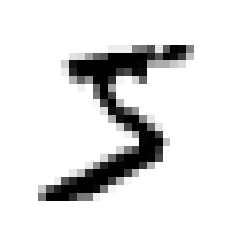

In [9]:
plt.imshow(X_train_full[0], cmap='binary')
plt.axis('off')
plt.show()

In [32]:
X_train_valid, X_train = X_train_full[:6000] / 255., X_train_full[6000:] / 255.
y_train_valid, y_train = y_train_full[:6000], y_train_full[6000:]
X_test = X_test / 255.

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(lr=1e-1),
              metrics= ["accuracy"]
             )

history = model.fit(X_train, y_train, epochs=100,
                   validation_data = (X_train_valid, y_train_valid),
                   callbacks = [keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2717 - accuracy: 0.9193 - val_loss: 0.1542 - val_accuracy: 0.9542
Epoch 2/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1115 - accuracy: 0.9668 - val_loss: 0.0866 - val_accuracy: 0.9743
Epoch 3/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0742 - accuracy: 0.9771 - val_loss: 0.0969 - val_accuracy: 0.9688
Epoch 4/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0535 - accuracy: 0.9834 - val_loss: 0.0791 - val_accuracy: 0.9752
Epoch 5/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0393 - accuracy: 0.9879 - val_loss: 0.0805 - val_accuracy: 0.9748
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0297 - accuracy: 0.9910 - val_loss: 0.0727 - val_accuracy: 0.9793
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0219 - accuracy: 0.9935 - val_loss: 0.0717 - val_ac

In [36]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0665 - accuracy: 0.9824


[0.06646956503391266, 0.9824000000953674]